In [16]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from numpy import random
from sklearn.metrics import accuracy_score, confusion_matrix


MAIN_PATH = '../data/traffic-signs-preprocessed/'

train_data = pd.read_pickle(os.path.join(MAIN_PATH, 'train.pickle'))
train_images = train_data['features']
train_labels = train_data['labels']

test_data = pd.read_pickle(os.path.join(MAIN_PATH, 'test.pickle'))
test_images = test_data['features']
test_labels = test_data['labels']


flatten_train_images = train_images.reshape(len(train_images), 32*32*3)
flatten_test_images = test_images.reshape(len(test_images), 32*32*3)


labels_lookup = pd.read_csv(os.path.join(MAIN_PATH, 'label_names.csv'))["SignName"]

Lets print some random traffic signs with corresponding labels in NxN box

<Figure size 1100x1100 with 0 Axes>

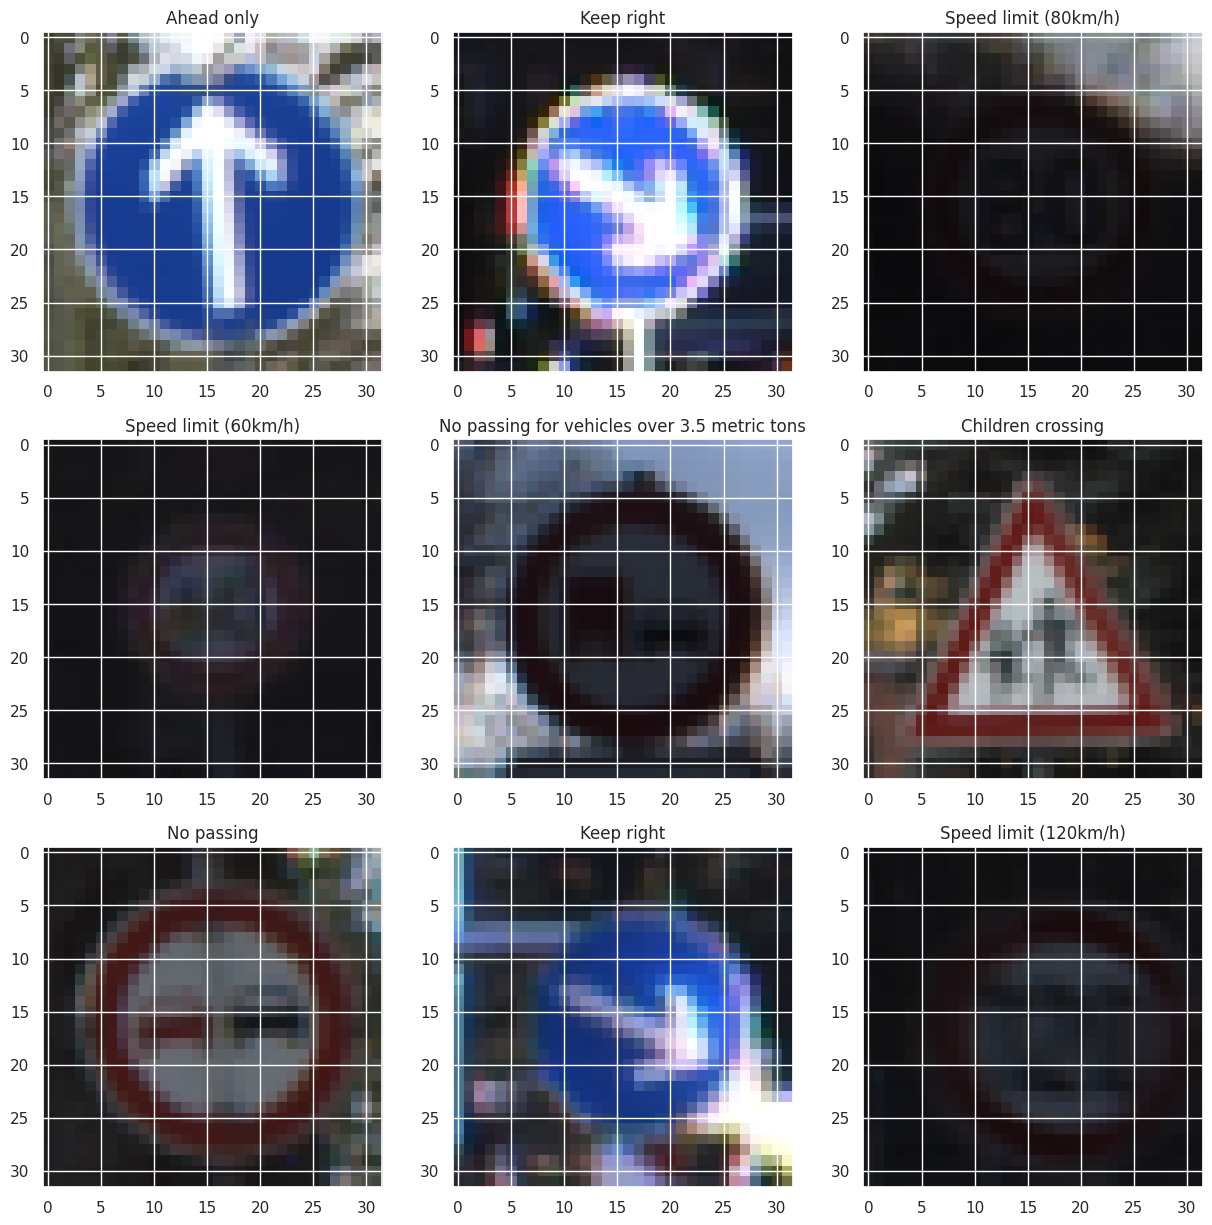

In [101]:
def print_traffic_signs(images, labels, n=3):
    plt.figure()
    f, axarr = plt.subplots(n, n, figsize=(15, 15))

    for i in range(0, n*n, n):
        indx = [random.randint(0, len(images)-1) for i in range(n)]
        for j in range(n):
            current_index = indx[j]
            current_name = labels_lookup[labels[current_index]]
            axarr[i // n, j].imshow(images[current_index])
            axarr[i // n, j].set_title(current_name)

    plt.show()

print_traffic_signs(train_images, train_labels)

**Easy**

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)
model.fit(flatten_train_images, train_labels)

Lets predict and measure, we'll use default top-1 accuracy (default accuracy), due to it's the most common metric.

In [20]:
test_prediction = model.predict(flatten_test_images)

print(accuracy_score(test_prediction, test_labels))

0.844338875692795


printing confusion matrix

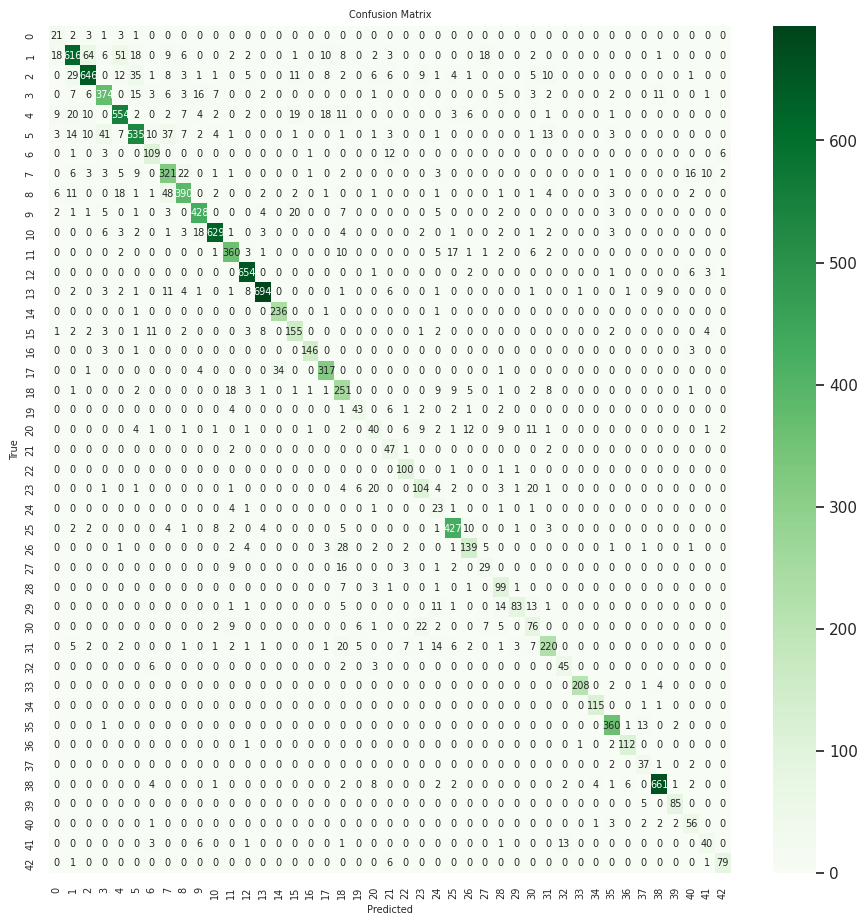

In [21]:
def generate_confusion_matrix(matrix):
    matrix = matrix.astype('float')

    sns.set(rc={'figure.figsize': (11, 11)})
    figure = sns.heatmap(
        matrix,
        annot=True,
        cmap='Greens',
        fmt='.0f',
        annot_kws={"size": 7}
    )

    figure.tick_params(labelsize=7)

    plt.xlabel('Predicted', fontsize=7)
    plt.ylabel('True', fontsize=7)
    plt.title('Confusion Matrix', fontsize=7)
    plt.show()


df_confusion = confusion_matrix(test_prediction, test_labels)
generate_confusion_matrix(df_confusion)


most often there is confusion with 1 and 3 indexes, it's the .. (code is below)

In [ ]:
print(labels_lookup[1], labels_lookup[3], sep="\n")

Speed limit (30km/h)
Speed limit (60km/h)


**Medium**

knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(flatten_train_images, train_labels)

In [ ]:
knn_pred = knn_model.predict(flatten_test_images)

In [ ]:
print(accuracy_score(knn_pred, test_labels))

0.3839271575613618


Naive Bayes classifier for multinomial models

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(flatten_train_images, train_labels)
nb_pred = nb_model.predict(flatten_test_images)

print(accuracy_score(nb_pred, test_labels))

0.29271575613618367


SVM

In [ ]:
from sklearn.svm import SVC

# Linear kernel
lc_svm_model = SVC(kernel='linear')
lc_svm_model.fit(flatten_train_images, train_labels)
lc_svm_pred = lc_svm_model.predict(flatten_test_images)

print(accuracy_score(lc_svm_pred, test_labels))

0.8


In [ ]:
# Polynomial kernel
pc_svm_model = SVC(kernel='poly')
pc_svm_model.fit(flatten_train_images, train_labels)
pc_svm_pred = pc_svm_model.predict(flatten_test_images)

print(accuracy_score(pc_svm_pred, test_labels))

0.5477434679334917


In [ ]:
# Radial Basis Function
rbfc_svm_model = SVC(kernel='rbf')
rbfc_svm_model.fit(flatten_train_images, train_labels)
rbfc_svm_pred = rbfc_svm_model.predict(flatten_test_images)

print(accuracy_score(rbfc_svm_pred, test_labels))

0.6841646872525733


As we see, the logistic regression shows us the best result, although we can try to change the "max_iter" argument for better perfomance.

The worst result gives a naive bayes approach, I guess, it's because in that approach we assume, that all features r independent, but apparantly, in plain image we have a certain relationship between successive pixels, colors change gradually

**Hard**

in the future we will use only linear regression, since it showed the best result on the original dataset

We'll act like this: consider all classes of pictures, define a variable n, which will indicate the number of pictures from each class.

We'll minimize n, so that the overall quality does not deteriorate too much; for this we'll use image augmentation

In [19]:
unique, counts = np.unique(train_labels, return_counts=True)
counts

array([ 180, 1980, 2010, 1260, 1770, 1650,  360, 1290, 1260, 1320, 1800,
       1170, 1890, 1920,  690,  540,  360,  990, 1080,  180,  300,  270,
        330,  450,  240, 1350,  540,  210,  480,  240,  390,  690,  210,
        599,  360, 1080,  330,  180, 1860,  270,  300,  210,  210])

as we see, minimal count for all classes is 180, lets define n = 150

In [292]:
from collections import defaultdict

n = 150

tmp_data = defaultdict(list)
tmp_labels = []
for i, x in enumerate(train_images):
    if len(tmp_data[train_labels[i]]) < n:
        tmp_data[train_labels[i]].append(x)
        tmp_labels.append(train_labels[i])

tmp1_data = []

for key, stack in tmp_data.items():
    for item in stack:
        tmp1_data.append(item)

minimal_train = np.array(tmp1_data)
minimal_labels = np.array(tmp_labels)


# of course, we should shuffle it
def unison_shuffle(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

minimal_train, minimal_labels = unison_shuffle(minimal_train, minimal_labels)

In [293]:
minimal_train.shape

(6450, 32, 32, 3)

print 2x2 box to ensure, that we've done alright

<Figure size 1100x1100 with 0 Axes>

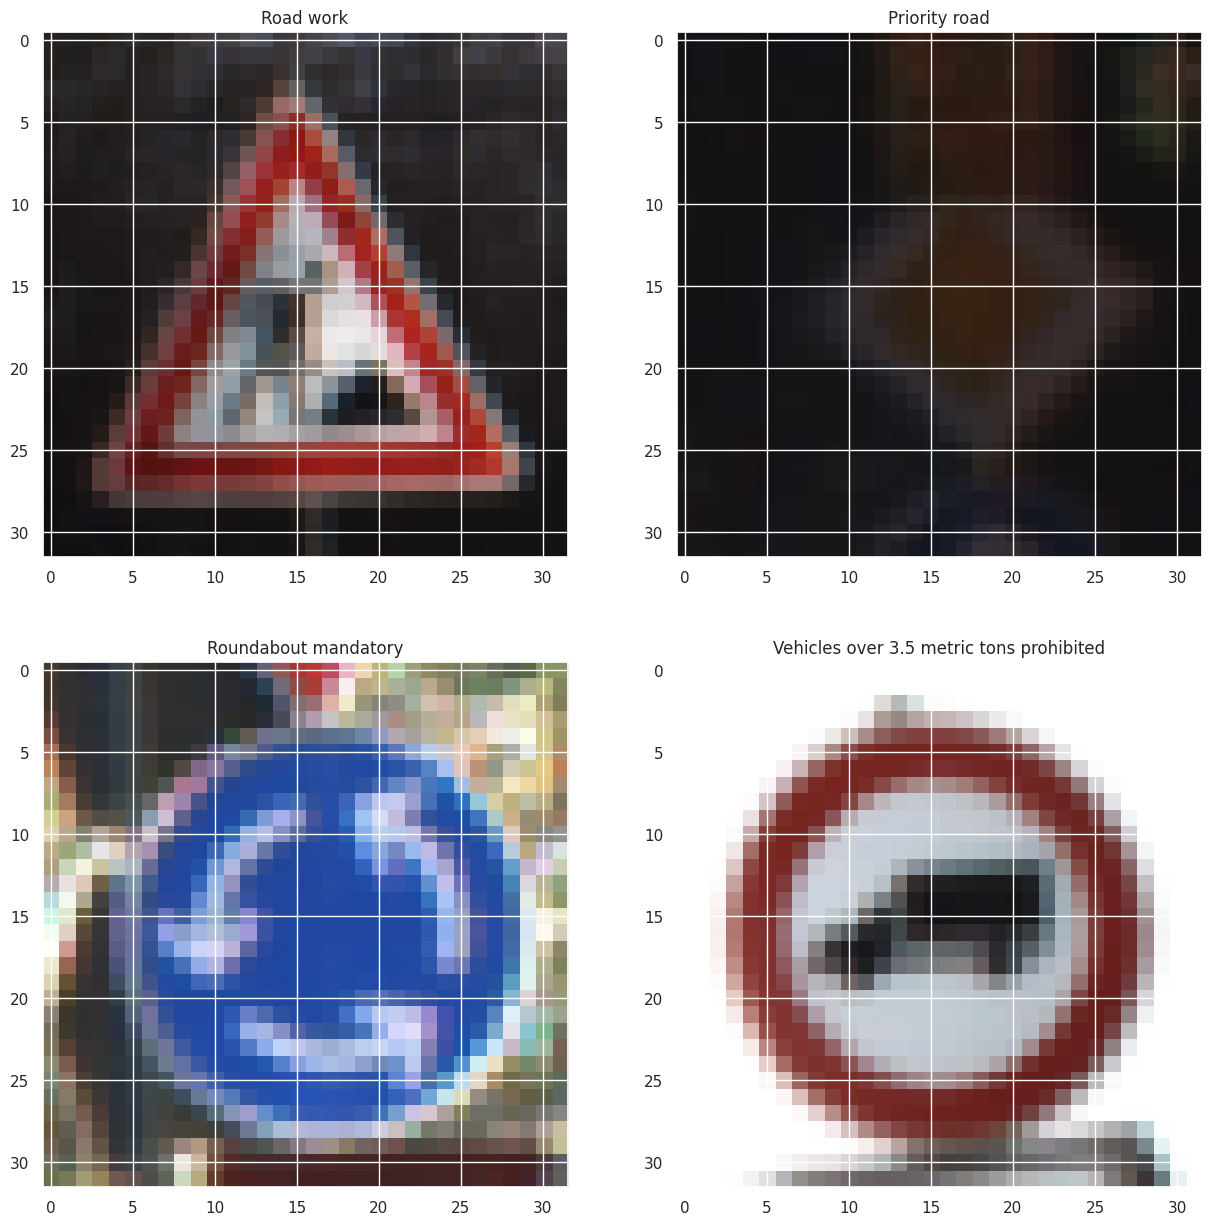

In [294]:
print_traffic_signs(
    minimal_train,
    minimal_labels,
    n=2
)

now, lets augmentate it by using code provided at kaggle dataset page

In [295]:
import cv2
import sys
sys.path.append('../data/traffic-signs-preprocessed')

from datasets_preparing import brightness_changing, \
                                rotation_changing, \
                                transformation_brightness_rotation, \
                                rotation_changing

applting augmentations and shuffling

In [296]:
def rgb_to_gray_image(img):
    y = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.merge((y, y, y))

In [297]:
aug_images, aug_labels = [], []

for i, x in enumerate(minimal_train):
    aug_images += [
                    x.astype(int),
                    rgb_to_gray_image(x).astype(int),
                    brightness_changing(x).astype(int),
                    rotation_changing(x).astype(int),
                    transformation_brightness_rotation(x).astype(int)
                ]
    aug_labels += [minimal_labels[i]]*5

aug_images, aug_labels = np.array(aug_images), np.array(aug_labels)
aug_images, aug_labels = unison_shuffle(aug_images, aug_labels)

lets take a look at our dataset after augmentations

<Figure size 1100x1100 with 0 Axes>

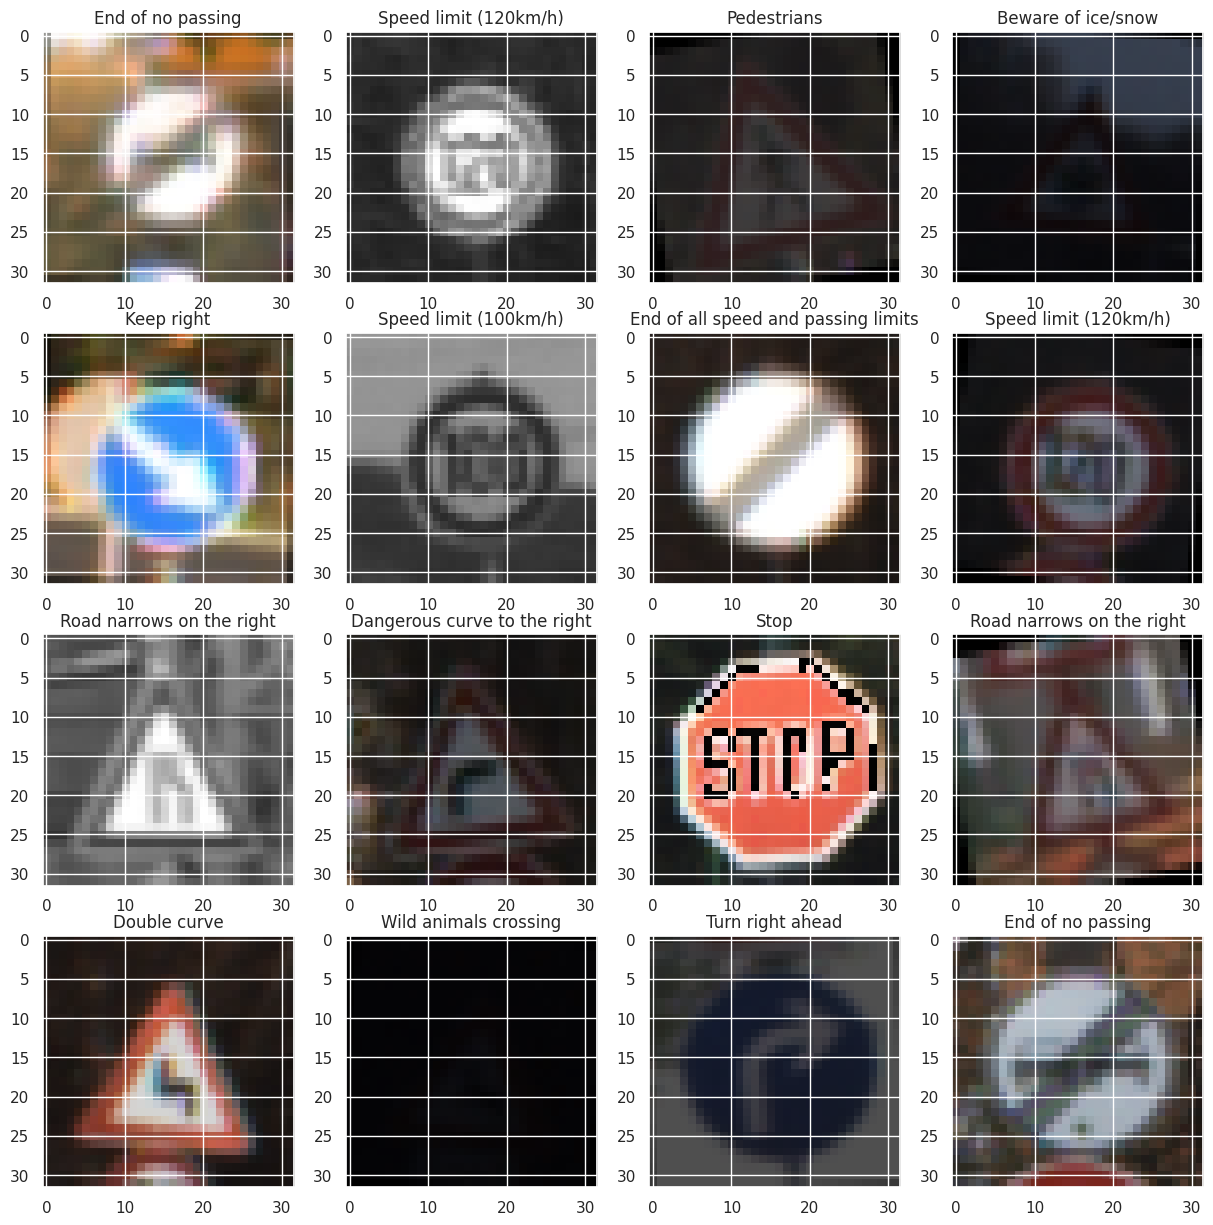

In [298]:
print_traffic_signs(
    aug_images,
    aug_labels,
    n=4
)

In [299]:
aug_images.shape

(32250, 32, 32, 3)

lets train the logistic regression & make predictions on initial test dataset

In [ ]:
model = LogisticRegression(max_iter=250)
model.fit(aug_images.reshape(len(aug_images), 32*32*3), aug_labels)

In [301]:
test_prediction = model.predict(flatten_test_images)

print(accuracy_score(test_prediction, test_labels))

0.6389548693586699


**Conclusion**

leaving literally 150 pictures of each class, we already get a very good top-1 accuracy, doubtless, we can improve this result by making better quality augmentation, it turns out that to achieve a good result it is not necessary to take 500-800 pictures of different classes, 150-200 is enough